# Basic neural network 

This notebook is made for learning purposes. The primary goal is to understand the underlying backpropagation algorithm that calculates the gradient of the cost function which in turn allows the network to learn. A network is created that is able to use three different activation functions and have any number of layers and units as long as memory allows it. The network is tested on the MNIST dataset and achieves an accuracy of 85% on this ten categories classification problem.  

## Notation for multilayer perceptrons 

We denote the unit values of the $l$'th layer of a neural network in vectorform as $a^{(l)}$. The vector is given by 

$$a^{(l)} = \sigma(z^{(l)})$$

Where $\sigma$ is some activation function and $z^{(l)}$ is given by 

$$z^{(l)} = W^{(l)}a^{(l-1)} + b^{(l)}$$

Where $W^{(l)}$ and $b^{(l)}$ are the weight matrix and bias terms, respectively, corresponding to the layer below. 
As an example, if x is a vector corresponding to a single observation and the layer consists of two layers, the final activations, $a^{(2)}$, are given by

$$a^{(2)} = \sigma(W^{(2)}\sigma(W^{(1)}x + b^{(1)}) + b^{(2)}) $$

Note that $x$ is treated as $a^{(0)}$. Adding more layers means that higher orders of $a$ can be found by iteratively using the newfound activations as input to the next matrix multiplication. Finding the activations by propagating forwards like this through the network is known as feedforwarding.

It is possible to expand the matrix multiplication such that more than one observation will be feedforwarded in the network at the same time. An example of this is by creating a matrix $X$ in which each row is a single observation $x_i$. If $X$ has n rows, we can find the first layer activations $A^{(1)}$ of n observations by

$$A^{(1)} = \sigma(X(W^{(1)})^T + b^{(1)})$$

and we can generally find $A^{(l)}$ as 

$$A^{(l)} = \sigma(A^{(l-1)}(W^{(l)})^T + b^{(l)})$$

The objective is to use an algorithm known as stochastic gradient descent to iteratively improve the weights and biases of the network and thus attain better predictions. 

## The MNIST dataset

We import the mnist dataset, which has 60000 images each of 28x28 pixels. Each image is a handdrawn digit. 

Examples of handwritten digits.


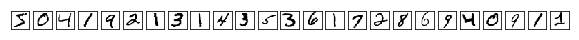

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist

# Load data. 
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Display some of the images.
print("Examples of handwritten digits.")
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(1,25,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train[i], cmap=plt.cm.binary)
    #plt.xlabel(class_names[y_train[i]])

# Reshape 2D images to flat arrays and scale pixels.    
x_train = x_train.reshape(60000, 28*28) / 255.0 
x_test = x_test.reshape(-1, 28*28) / 255.0

## Setting up the network

The part of the neural network that learns over time is the weights and biases. We start out with a function that creates the weights and biases. A bias vector $b^{(l)}$ has as many elements as there are units in layer $l$. A weight matrix $W^{(l)}$ maps a vector of dimension $dim(a^{(l-1)})$ to $dim(a^{(l)})$. So if for instance $dim(a^{(2)})=100$ and $dim(a^{(3)})=200$, the matrix $W^{(3)}$ has the size $[200, 100]$. 

In [3]:
import numpy as np

def create_weights_and_biases(input_shape, nodes):
    """Returns two lists. A list of all weight matrices and one
    of all biases. The inputs are 
    
        input_shape: a tuple (num_observations, num_features).
        
        nodes: is a list containing the number of 
            nodes in each layer."""
    weights = []
    biases = []
    for l in range(len(nodes)):
        if l == 0:
            w = np.random.normal(size=(nodes[l], input_shape[1]))
            b = np.random.normal(size=(nodes[l]))
        else:
            w = np.random.normal(size=(nodes[l], nodes[l-1]))
            b = np.random.normal(size=(nodes[l]))
        weights.append(w)
        biases.append(b)
    
    return weights, biases

## Feedforward 

When running through the network to get the output it is important to save the $A^{(l)}$ and $Z^{(l)}$ matrices that are generated at each layer. These will be necessary when performing the backpropagation algorithm. Within the feedforward function we see that at each layer the calculations $Z^{(l)} = A^{(l-1)}(W^{(l)})^T + b^{(l)}$ and $A^{(l)} = \sigma(Z^{(l)})$ are performed. 

In [4]:
def feedforward(x, weights, biases, sigmas):
    """Runs through the network.
    Outputs the z's and a's in a list form.
    
        input x: matrix where each column corresponds to an observation vector.
        input weights: the weight matrices of each layer (from 1 to L).
        input biases: the biases of each layer (from 1 to L).
        input sigmas: the activation functions for each layer in a list."""
    z_list = []
    a_list = []
    a = x
    for w, b, sigma in zip(weights, biases, sigmas):
        z = np.matmul(a, w.T) + b
        a = sigma(z)
        
        z_list.append(z)
        a_list.append(a)
    return z_list, a_list

In the feedforward function we used `sigmas` as a list of activation functions. We now define the activation functions. First the *sigmoid function* which is often used and ensures that activations lie between -1 and 1.  

$$ \text{sigmoid}(x) = \frac{1}{1 + e^{-x}}
\qquad\text{where}\qquad
\text{sigmoid}'(x) = \text{sigmoid}(x)(1 - \text{sigmoid}(x))$$

The *softmax function* approximates the argmax function in that it makes the largest value of a layer close to one while others are close to zero. This is useful for many types of classification and will be used in the final layer of this particular neural network.

$$ \text{softmax}(x_j) = \frac{e^{x_j}}{\sum_k e^{x_k}} 
\qquad\text{where}\qquad
\text{softmax}'(x_j) = \text{softmax}(x_j)(1 - \text{softmax}(x_j))
$$

The *relu function* (rectified linear) is likely the most used activation function for so-called dense layers.

$$ \text{relu}(x) = \text{argmax}(x,0)
\qquad\text{where}\qquad
\text{relu}'(x) = 
\begin{cases} 
0 & \text{if } x \leq 0 \\
1 & \text{otherwise } 
\end{cases}
$$

In [5]:
def sigmoid(x, deriv=False):
    if deriv == False:
        return 1 / (1 + np.exp(-x))
    else:
        return sigmoid(x) * (1 - sigmoid(x))

def softmax(x, deriv=False):
    # x is a row i this case.
    if deriv == False:
        softmatrix = np.zeros(x.shape)
        for i, row in enumerate(x):
            exps = np.exp(row)
            softmatrix[i] = np.exp(row) / exps.sum()
        return softmatrix
    else:
        return softmax(x) * (1 - softmax(x))
    
def relu(x, deriv=False):
    if deriv == False:
        x[x <= 0] = 0
        return x
    else:
        x[x <= 0] = 0
        x[x > 0] = 1
        return x

## Cost function

In order to tell how well the network performs we define a cost (or loss) function. The function is what the network tries to minimize by changing the weights and biases. The cost function of a single observation $x$ with m elements is denoted by $C$. 

$$ C = \frac{1}{2 m} \sum_i (a_i^{(L)} - y_i)^2 $$

We can then evaluate the general loss to be the mean of all loss scores from all observations.

To make the this equation work we must first change `y_train`. When we get the $y$ labels from the dataset they are, for example if there were four labels, of the form `[0, 5, 4, 9]`. In order to calculate the the loss properly we must put this into a one-hot-encoded form. The `[0, 5, 4, 9]` would then become a matrix looking like this

$$\begin{bmatrix} 
1 && 0 && 0 && 0 && 0 && 0 && 0 && 0 && 0 && 0 \\ 
0 && 0 && 0 && 0 && 0 && 1 && 0 && 0 && 0 && 0 \\
0 && 0 && 0 && 0 && 1 && 0 && 0 && 0 && 0 && 0 \\
0 && 0 && 0 && 0 && 0 && 0 && 0 && 0 && 0 && 1 \\
\end{bmatrix} $$

In [6]:
def simple_loss(y_preds, y_targets):
    """Calculates the loss."""
    y_one_hot = one_hot(y_targets)
    return ((y_preds - y_one_hot)**2).mean(axis=1).mean() # The last .mean() gives the mean of all observations/rows.

def one_hot(y):
    """ Create a matrix where each row corresponds to an observation
    and has ten columns. In every row only one value is 1 and 
    the rest are zero."""
    y_one_hot = np.zeros((len(y),10))
    for i, target in enumerate(y):
        y_one_hot[i, target] = 1
    return y_one_hot

## Backpropagation

In order to perform the backpropagation it is useful to define the *error* $\delta_j^{(l)}$ of unit $j$ in layer $l$ by

$$\delta_j^{(l)} = \frac{\partial C}{\partial z_j^{(l)}} $$

This single element $\delta_j^{(l)}$ is a single entry of a vector $\delta^{(l)}$ and for the sake of linear algebra can be put into a matrix, $\Delta^{(l)}$, as a row where each row corresponds to a calculation for a particular observation $x$. If we now define $L$ to be the final layer of the neural network, each $\Delta^{(l)}$ can be found using the formulas

$$\Delta^{(L)} = \nabla_{a^{(L)}} C \odot \sigma(Z^{(L)})$$

$$\Delta^{(l)} = (\Delta^{(l+1)} W^{(l+1)}) \odot \sigma'(Z^{(l)})$$

These deltas are useful because of their relationship with $\frac{\partial C}{\partial W}$ and therefore grants the gradient needed to perform the stochastic gradient descent algorithm.

$$\frac{\partial C}{\partial b^{(l)}} = \delta^{(l)} $$
$$\frac{\partial C}{\partial W^{(l)}} = (a^{(l-1)})^T \delta^{(l)} $$

In [7]:
def backpropagation(x, y, weights, biases, activations):
    """Calculates the gradients with respect to all weights and biases."""
    
    # Prepare y and the z and a lists.
    y = one_hot(y)
    z_list, a_list = feedforward(x, weights, biases, activations)
    DELTAs = []
    
    # Since we propagate backwards, we work with all matrices in reverse order
    reverse_list = np.flip(list(zip(z_list, a_list, activations)), axis=0)
    
    for i, (z, a, activation) in enumerate(reverse_list):
        if i == 0:                                                # Final layer, L.
            DELTA = (a - y) * activation(z, deriv=True)           # Here dC/da is given by (a - y).
        else:
            DELTA = np.matmul(DELTA, weights[-i]) * activation(z, deriv=True)
        DELTAs.insert(0, DELTA)
    
    # Create the gradients of C. 
    # DELTAs come in order DELTA 1, DELTA 2, ..., DELTA L-1, DELTA L.
    a_list.insert(0, x)
    delC_delbs = []
    delC_delWs = []
    BATCH_SIZE = x.shape[0] # Size of the batch feeded into the backpropagation algorithm.
    for i, DELTA in enumerate(DELTAs):
        delC_delb = np.zeros((BATCH_SIZE, biases[i].shape[0]))
        delC_delW = np.zeros((BATCH_SIZE, weights[i].shape[0], weights[i].shape[1]))
        for j, delta in enumerate(DELTA):
            delC_delb[j] = delta
            delC_delW[j] = np.matmul(delta.reshape(-1, 1), a_list[i][j].reshape(1, -1))
        delC_delbs.append(delC_delb.mean(axis=0)) # Calculate the mean of the biases for all observations in batch.
        delC_delWs.append(delC_delW.mean(axis=0)) # Calculate the mean of the weights for all observations in batch. 
    
    return delC_delWs, delC_delbs

## Training the network

Training the network works with the help of stochastic gradient descent. Any weight $w_{ij}^{(l)}$ can be iteratively updated by using a forward pass followed by a backward pass to gain the gradient $\nabla_w C$. The weights $w$ are updated with

$$ w := w + \eta \nabla_w C$$

Where $\eta$ is a scaler called the *learning rate*. This process is known as stochastic gradient descent and is a simple algorithm for updating the weights and biases. Each time a gradient has been computed and the weights updated is called an epoch. 

In [27]:
from sklearn.metrics import accuracy_score

def train(x, y, nodes=[100, 100, 10], activations=[sigmoid, sigmoid, softmax], 
          learning_rate=10, batch_size=128, epochs=5, validation_data=None):
    """Do some training."""
    
    # Create the weights and biases
    weights, biases = create_weights_and_biases(input_shape=x.shape, nodes=nodes)
    
    # Calculate the number of batches.
    num_runs = int(x.shape[0] / batch_size + 1)
    accs, losses, val_accs, val_losses = [], [], [], []
    
    # Start the loop. 
    for i in range(epochs):
        print("Epoch ", str(i + 1))
        
        # Perform this operation for each batch.
        for j in range(num_runs):
            if (j+1)*batch_size <= x_train.shape[0]:
                x_batch = x[j*batch_size:(j+1)*batch_size]
                y_batch = y[j*batch_size:(j+1)*batch_size]
            else:
                x_batch = x[j*batch_size:]
                y_batch = y[j*batch_size:]
            
            # Get the changes in weights and biases.
            delC_delW, delC_delb = backpropagation(x_batch, y_batch, weights, biases, activations)
            
            # Update the weights and biases.
            for k in range(len(weights)):
                weights[k] = weights[k] - (learning_rate * x_batch.shape[0] / x.shape[0] )*delC_delW[k]
                biases[k] = biases[k] - (learning_rate * x_batch.shape[0] / x.shape[0])*delC_delb[k]
        
        # Calculate accuracy and loss.
        z_list, a_list = feedforward(x, weights, biases, activations)
        preds = predictions(a_list[-1])
        acc = accuracy_score(preds, y)
        loss = simple_loss(a_list[-1], y)
        
        # Calculate the validation accuracy and loss. 
        if not validation_data:
            val_acc = "not computed."
            val_loss = "not computed."
        else:
            x_val = validation_data[0]
            y_val = validation_data[1]
            val_z_list, val_a_list = feedforward(x_val, weights, biases, activations)
            val_preds = predictions(val_a_list[-1])
            val_acc = accuracy_score(val_preds, y_val)
            val_loss = simple_loss(val_a_list[-1], y_val)
        
        # Create lists of the accuracies and losses.
        accs.append(acc)
        losses.append(loss)
        val_accs.append(val_acc)
        val_losses.append(val_loss)

        print("Accuracy: " + str(acc))
        print("Loss: " + str(loss))
        print("Validation accuracy: " + str(val_acc))
        print("Validation loss: " + str(val_loss))
        
    return accs, losses, val_accs, val_losses

def predictions(y_preds):
    """Calculates the predictions where the input
    is the list of a's."""
    preds=[]
    for probs in y_preds:
        pred = probs.argmax()
        preds.append(pred)
    return preds

Finally we are able to train the network and see the results. During testing it seemed that a learning rate of 130 seemed to be a close to optimal choice.

In [29]:
X = x_train
y = y_train

acc, loss, val_acc, val_loss = train(X, y, learning_rate=130, epochs=25, validation_data=[x_test, y_test])

Epoch  1
Accuracy: 0.3171833333333333
Loss: 0.08110004763165429
Validation accuracy: 0.3158
Validation loss: 0.08115256676979106
Epoch  2
Accuracy: 0.48568333333333336
Loss: 0.06623017644285821
Validation accuracy: 0.488
Validation loss: 0.06618688877139577
Epoch  3
Accuracy: 0.5873833333333334
Loss: 0.05539197636159196
Validation accuracy: 0.5966
Validation loss: 0.05507492321770609
Epoch  4
Accuracy: 0.6491166666666667
Loss: 0.04779592135601581
Validation accuracy: 0.6568
Validation loss: 0.04737912422609657
Epoch  5
Accuracy: 0.694
Loss: 0.042056368900066095
Validation accuracy: 0.7016
Validation loss: 0.04140257277374549
Epoch  6
Accuracy: 0.7291833333333333
Loss: 0.03776973582559614
Validation accuracy: 0.7413
Validation loss: 0.03688982780860543
Epoch  7
Accuracy: 0.75515
Loss: 0.03450708486967532
Validation accuracy: 0.7663
Validation loss: 0.033499956583639696
Epoch  8
Accuracy: 0.7743666666666666
Loss: 0.032007437172935464
Validation accuracy: 0.7834
Validation loss: 0.0309630

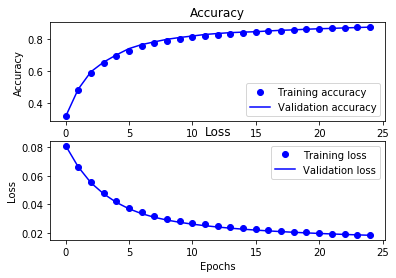

In [32]:
# Plot accuracy.
plt.figure(1)
plt.subplot(211)
plt.plot(list(range(25)), acc, 'bo', label='Training accuracy')
plt.plot(list(range(25)), val_acc, 'b', label='Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy')
plt.legend()

# Plot loss.
plt.subplot(212)
plt.plot(list(range(25)), loss, 'bo', label='Training loss')
plt.plot(list(range(25)), val_loss, 'b', label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss')
plt.legend()

## Conclusion

Judging by the slope of the accuracy and loss progressions it appears that even after 25 epochs the network is still able to perform better even though very slowly from this point onwards. Overfitting has not yet been reached and we end up with an accuracy of around 85%. 

The network still has room for improvement. Notably using a different cost function, such as cross entropy, might make the network learn faster. Regularization and convolutional layers would also help. A disappointment to me was that the network did not run when using relus due to division by zero, which is an issue I have yet to fix. 